In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
import numpy as np
import spacy
import pickle
import nltk
import sklearn.manifold
from random import getrandbits
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from collections import Counter
from nltk.cluster import kmeans, cosine_distance

In [3]:
path = 'tag/spanishEtiquetado*'   
files = glob.glob(path) 

datawiki = ''
for file in files:
    text_wiki = open(file,'r', encoding='ISO-8859-2')
    datawiki += text_wiki.read()
    text_wiki.close()

In [4]:
def parse_sents(text):
    sentences = text.split('\n\n')
    return sentences

In [5]:
sentences = parse_sents(datawiki)

In [6]:
print(sentences[0])

<doc id="2218136" title="Vedad Ibi¨evi?" nonfiltered="1" processed="1" dbindex="480001">
Vedad vedar VMM02P0 0
Ibi¨evi ibi¨evi NP00000 0
, , Fc 0
nacido nacer VMP00SM 00249716
el el DA0MS0 0
6_de_agosto_de_1984 [??:6/8/1984:??.??:??] W 0
en en SPS00 0
Vlasenica vlasenica NP00000 0
, , Fc 0
Yugoslavia yugoslavia NP00000 0
( ( Fpa 0
actual actual AQ0CS0 01667781
Bosnia bosnia NP00000 0
y y CC 0
Herzegovina herzegovina NP00000 0
) ) Fpt 0
es ser VSIP3S0 01775973
un uno DI0MS0 0
futbolista futbolista NCCS000 0
bosnio bosnio AQ0MS0 02731920
que que PR0CN000 0
juega jugar VMIP3S0 00727813
como como CS 0
delantero delantero NCMS000 00466114
en en SPS00 0
el el DA0MS0 0
TSG tsg NP00000 0
1899 1899 Z 0
Hoffenheim_de_la_Bundesliga_de_Alemania hoffenheim_de_la_bundesliga_de_alemania NP00000 0
. . Fp 0


In [8]:
words_in_sent = []
for sentence in sentences:
    if len(sentence) > 10:
        words_in_sent.append(sentence.split('\n'))

In [10]:
print(words_in_sent[:5])

[['<doc id="2218136" title="Vedad Ibi¨evi?" nonfiltered="1" processed="1" dbindex="480001">', 'Vedad vedar VMM02P0 0', 'Ibi¨evi ibi¨evi NP00000 0', ', , Fc 0', 'nacido nacer VMP00SM 00249716', 'el el DA0MS0 0', '6_de_agosto_de_1984 [??:6/8/1984:??.??:??] W 0', 'en en SPS00 0', 'Vlasenica vlasenica NP00000 0', ', , Fc 0', 'Yugoslavia yugoslavia NP00000 0', '( ( Fpa 0', 'actual actual AQ0CS0 01667781', 'Bosnia bosnia NP00000 0', 'y y CC 0', 'Herzegovina herzegovina NP00000 0', ') ) Fpt 0', 'es ser VSIP3S0 01775973', 'un uno DI0MS0 0', 'futbolista futbolista NCCS000 0', 'bosnio bosnio AQ0MS0 02731920', 'que que PR0CN000 0', 'juega jugar VMIP3S0 00727813', 'como como CS 0', 'delantero delantero NCMS000 00466114', 'en en SPS00 0', 'el el DA0MS0 0', 'TSG tsg NP00000 0', '1899 1899 Z 0', 'Hoffenheim_de_la_Bundesliga_de_Alemania hoffenheim_de_la_bundesliga_de_alemania NP00000 0', '. . Fp 0'], ['Trayectoria trayectoria NP00000 06709272', '. . Fp 0'], ['Como como CS 0', 'consecuencia consecuenci

In [16]:
featured_words = []
for sent in words_in_sent:
    if bool(getrandbits(1)):
        s = []
        for word in sent:
            if not re.match("<doc", word) and not re.match("</doc", word):
                s.append(word.split())
        featured_words.append(s)


In [23]:
allwords = []
for sent in featured_words:
    for word in sent:
        if len(word) < 4:
            continue
        lemma, pos, wclass = word[1], word[2], word[3]
        if pos[0] == 'F' or pos[0] == 'Z':
            continue
        if wclass == 0:
            continue
        allwords.append(lemma)
        
counts = Counter(allwords)

In [ ]:
threshold_w = 10
words = []
words_dict = {}
i = 0
for sent in featured_words:
    for word in sent:
        if len(word) < 4:
            continue
        lemma, pos = word[1], word[2]
        if counts[lemma] < threshold_w:
            continue
        if pos[0] == 'F' or pos[0] == 'Z':
            continue
        if wclass == 0:
            continue
        words.append(lemma)
        if lemma not in words_dict:
            words_dict[lemma] = i
            i += 1

In [34]:
dict_words = []
class_words = []
threshold_w = 10
threshold_c = 20

for sent in featured_words:
    for index, word in enumerate(sent):
        if len(word) < 4:
            continue
        lemma, pos, wclass = word[1], word[2], word[3]
        if pos[0] == 'F' or pos[0] == 'Z':
            continue
        if counts[lemma] < threshold_w:
            continue
        features = {}

        features[lemma] = 1
        features[pos[0]] = 1
        if len(pos) > 1:
            features[pos[1]] = 1
        if len(pos) > 2:
            if not pos[2] == '0':
                features[pos[2]] = 1

        if not word == sent[0]:
            word_before = sent[index - 1]
            if counts[word_before[1]] > threshold_c:
                izq_word = 'izq' + word_before[1]
                izq_pos = 'izq' + word_before[2][:2]
                features[izq_word] = 1
                features[izq_pos] = 1

        if not word == sent[len(sent) - 1]:
            word_after = sent[index + 1]
            if counts[word_after[1]] > threshold_c:
                der_word = 'der' + word_after[1]
                der_pos = 'der' + word_after[2][:2]
                features[der_word] = 1
                features[der_pos] = 1

        dict_words.append(features)
        class_words.append(wclass)

In [35]:
print(dict_words[:10])
print(class_words[:10])

[{'V': 1, 'derDA': 1, 'M': 1, 'nacido': 1, 'nacer': 1, 'P': 1, 'derel': 1}, {'A': 1, 'D': 1, 'el': 1, 'izqnacer': 1, 'izqVM': 1}, {'P': 1, 'S': 1, 'en': 1}, {'A': 1, 'actual': 1, 'Q': 1}, {'C': 1, 'y': 1}, {'V': 1, 'es': 1, 'deruno': 1, 'S': 1, 'derDI': 1, 'I': 1, 'ser': 1}, {'derNC': 1, 'D': 1, 'izqser': 1, 'izqVS': 1, 'I': 1, 'derfutbolista': 1, 'uno': 1, 'un': 1}, {'izquno': 1, 'izqDI': 1, 'futbolista': 1, 'C': 1, 'N': 1}, {'que': 1, 'derVM': 1, 'P': 1, 'derjugar': 1, 'R': 1}, {'V': 1, 'dercomo': 1, 'M': 1, 'izqque': 1, 'I': 1, 'juega': 1, 'jugar': 1, 'derCS': 1, 'izqPR': 1}]
['00249716', '0', '0', '01667781', '0', '01775973', '0', '0', '0', '00727813']


In [222]:
v = DictVectorizer(dtype=np.bool_, sparse=False)
matrix_words = v.fit_transform(dict_words)

(15, 60)


In [225]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(matrix_words, class_words)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(matrix_words)

(15, 15)


In [ ]:
mfinal = np.zeros((len(words_dict), X_new.shape[1]))

for index, lemma in enumerate(words):
    i = words_dict[lemma]
    mfinal[i] += X_new[index]

In [236]:
from sklearn.preprocessing import normalize
normed_matrix = normalize(mfinal)

(15, 15)


In [ ]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(normed_matrix, True)
    return clusters

In [ ]:
c50 =  clustering(50)
c100 = clustering(100)
c150 = clustering(150)

In [ ]:
filename = "trained/wiki_c50.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c50, fileObj)
fileObj.close()
filename = "trained/wiki_c100.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c100, fileObj)
fileObj.close()
filename = "trained/wiki_c150.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c150, fileObj)
fileObj.close()

In [10]:
filename = "trained/wiki_wordsdict.pickle"
with open(filename, 'rb') as f:
    words_dict2 = pickle.load(f)

In [4]:
filename = "trained/wiki_c50.pickle"
with open(filename, 'rb') as f:
    c50 = pickle.load(f)
filename = "trained/wiki_c100.pickle"
with open(filename, 'rb') as f:
    c100 = pickle.load(f)
filename = "trained/wiki_c150.pickle"
with open(filename, 'rb') as f:
    c150 = pickle.load(f)

In [13]:
printer = [word for word in words_dict2 if c50[words_dict2[word]] == c50[words_dict2["presidente"]]]
print(printer)

['y', 'guitarra', 'obra', 'siguiente', 'cada', 'fuerte', 'derecho', 'distribución', 'inglés', 'hacer', 'popular', 'decidir', 'capacidad', 'of', 'campo', 'por', 'ańo', 'muy', 'quedar', 'a', 'nivel', 'revista', 'principal', 'madre', 'considerar', 'su', 'importante', 'in', 'todo', 'and', 'necesario', 'la', 'poder', 'oeste', 'en', 'alguno', 'barrio', 'e', 'regresar', 'at', 'crear', 'dentro_de', 'población', 'haber', 'casa', 'así', 'entre', 'endofarticle', 'insee', 'ordenar', 'perteneciente', 'servicio', 'semana', 'paso', 'hermano', 'estar', 'ciudad', 'conocer', 'dios', 'el', 'mejor', 'guerra', 'más', 'entrar', 'ser', 'comenzar', 'así_como', 'bajo', 'sustituir', 'equipo', 'fecha', 'desde', 'cantón', 'contar', 'él', 'disco', 'estudio', 'francés', 'no', 'final', 'ejército', 'programa', 'si', 'tomar', 'también', 'para', 'que', 'luego_de', 'de', 'nuevo', 'álbum', 'ir', 'medio', 'padre', 'destacar', 'capital', 'tener', 'enlace', 'existir', 'otro', 'como', 'gran', 'rey', 'durante', 'mismo', 'ese'

In [14]:
printer = [word for word in words_dict2 if c100[words_dict2[word]] == c100[words_dict2["presidente"]]]
print(printer)

['y', 'guitarra', 'obra', 'siguiente', 'derecho', 'hacer', 'decidir', 'por', 'ańo', 'casi', 'muy', 'a', 'nivel', 'revista', 'principal', 'su', 'importante', 'todo', 'municipal', 'poder', 'en', 'técnica', 'barrio', 'e', 'at', 'crear', 'así', 'endofarticle', 'ordenar', 'perteneciente', 'servicio', 'día', 'estar', 'ciudad', 'conocer', 'el', 'poco', 'más', 'ser', 'así_como', 'bajo', 'eln', 'nacer', 'equipo', 'desde', 'cantón', 'los', 'ganar', 'él', 'disco', 'francés', 'aparecer', 'final', 'si', 'para', 'que', 'de', 'nuevo', 'medio', 'donde', 'capital', 'tener', 'enlace', 'existir', 'otro', 'como', 'rey', 'planta', 'norte', '1', 'se', 'méxico', 'externo', 'sobre', 'hecho', 'uno', 'referencias', 'o', 'historia', 'grupo', 'cambiar', 'decir', 'acabar', 'tiempo', 'película', 'hasta', 'imagen', 'con']


In [15]:
printer = [word for word in words_dict2 if c150[words_dict2[word]] == c150[words_dict2["presidente"]]]
print(printer)

['cierto', 'y', 'demografía', 's', 'inglés', 'cuando', 'hacer', 'decidir', 'of', 'por', 'ańo', 'a', 'principal', 'su', 'importante', 'todo', 'and', 'interpretar', 'cual', 'en', 'et', 'alguno', 'e', 'at', 'casa', 'entre', 'endofarticle', 'estado', 'hermano', 'ciudad', 'conocer', 'el', 'guerra', 'poco', 'más', 'ser', 'así_como', 'bajo', 'sustituir', 'formación', 'continuar', 'tierra', 'no', 'final', 'si', 'on', 'tomar', 'también', 'para', 'que', 'construcción', 'parte', 'de', 'nuevo', 'enlace', 'existir', 'otro', 'gran', 'rey', 'pequeńo', 'durante', 'planta', '1', 'se', 'país', 'uno', 'o', 'le', 'acabar', 'les', 'tiempo', 'película', 'hasta', 'obama', 'con', 'pieza', 'nombre']


In [1]:
nlp = spacy.load('es', vectors=False, entity=False)

In [3]:
filename = "prueba.txt"
text_file = open(filename, "r")
dataset = text_file.read()
text_file.close()

In [4]:
doc = nlp(dataset)

In [110]:
print(doc[52], sents[1][12], len(sents[0]), sents[1][len(sents[1]) - 1] == doc[52])
print(sents[0], sents[1])
print(sents[1])

. . 31 True
"Lo que sostiene a la pareja es el amor"
Clara Crespo (50) y Rodolfo Martínez (54) no se imaginan uno sin el otro. Hace 26 años que están casados, y tienen cuatro hijas mujeres.
Hace 26 años que están casados, y tienen cuatro hijas mujeres.


In [36]:
sents = [sent for sent in doc.sents if len(sent) > 10]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            if word.pos_ == 'PROPN':
                words_lemma.append(word.text)
            else:
                words_lemma.append(word.lemma_)
            
counts = Counter(words_lemma)

In [37]:
print(counts)

Counter({'de': 91, 'que': 74, 'la': 59, 'y': 51, 'el': 44, 'a': 41, 'los': 35, 'en': 34, 'es': 27, 'se': 22, 'no': 21, 'las': 20, 'una': 17, 'más': 13, 'un': 13, 'por': 12, 'lo': 12, 'para': 11, 'cuando': 11, 'con': 10, 'años': 9, 'uno': 9, 'del': 9, 'me': 8, 'nos': 8, 'otro': 7, 'su': 7, 'Pedro': 7, 'son': 7, 'tiempo': 6, 'todo': 6, 'siempre': 6, 'o': 6, 'Educación': 6, 'han': 6, 'tan': 6, 'veces': 5, 'gusta': 5, 'Mary': 5, 'pero': 5, 'hay': 5, 'dos': 5, 'vida': 5, 'día': 5, 'dice': 4, 'sin': 4, 'pasión': 4, 'ya': 4, 'también': 4, 'amor': 4, 'hace': 4, 'conflicto': 4, 'qué': 4, 'contra': 4, 'toma': 4, 'proyecto': 4, 'casados': 4, 'acuerdo': 4, 'asegura': 4, 'cosas': 4, 'Daniel': 4, 'sino': 3, 'somos': 3, 'llevan': 3, 'Clara': 3, 'si': 3, 'canales': 3, 'chicas': 3, 'hermosa': 3, 'mujer': 3, 'forma': 3, 'les': 3, 'estar': 3, 'edificios': 3, 'juntos': 3, 'después': 3, 'medio': 3, 'escolares': 3, 'fue': 3, 'educación': 3, 'común': 3, 'entre': 3, 'refugio': 3, 'tomas': 3, 'al': 3, 'como': 

In [43]:
# El tag es un sólo string con todo. Es de la forma:
# 'VERB__Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin'
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:] 
    tags = tags.split("|")
    return tags

In [117]:
lemma_file = open("lemmatization-es.txt", "r")
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]

In [42]:
200 < 250 < 55

False

In [118]:
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word

In [119]:
# Crear diccionario
dicc = {}
list_dicc = {}
word_id = 0
#threshold_w = 100
threshold_c = 0

for word in words:
    if not word.is_alpha:
        continue
    if word.pos_ == 'PROPN':
        w = word.text
        word_tripla = 'PROPN'
    else:
        w = word.lemma_
        word_tripla = w
        
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    #if not word.pos_ == 'PROPN':
    tags = parse_tags(word)
    for tag in tags:
        if tag == '_':
            continue
        if not tag in features:
            features[tag] = 0
        features[tag] += 1

    if not word == sent[0]:
        context_izq = doc[word.i - 1] 
        if context_izq.pos_ == 'PROPN':
            ci = context_izq.text
        else:
            ci = context_izq.lemma_
        if counts[ci] > threshold_c:
            if context_izq.pos_ == 'PROPN':
                c_izq = "1IZQ__PROPN"
            elif str.isdigit(ci):
                if ci < 1000:
                    c_izq = "1IZQ__NUM__SMALL"
                elif 1000 <= ci < 3000:
                    c_izq = "1IZQ__NUM__YEAR"
                else:
                    c_izq = "1IZQ__NUM__BIG"
            elif context_izq.is_alpha:
                c_izq = "1IZQ__" + lemmatize(ci)
            if not c_izq in features:
                features[c_izq] = 0
            features[c_izq] += 1

    if not word == sent[len(sent) - 1]:
        context_der = doc[word.i + 1]
        if context_der.pos_ == 'PROPN':
            cd = context_der.text
        else:
            cd = context_der.lemma_
        if counts[cd] > threshold_c:
            if context_der.pos_ == 'PROPN':
                c_der = "1DER__PROPN"
            elif str.isdigit(cd):
                if cd < 1000:
                    c_der = "1DER__NUM__SMALL"
                elif 1000 <= cd < 3000:
                    c_der = "1DER__NUM__YEAR"
                else:
                    c_der = "1DER__NUM__BIG"
            elif context_der.is_alpha:
                c_der = "1DER__" + lemmatize(cd)
            if not c_der in features:
                features[c_der] = 0
            features[c_der] += 1

    if word.head.pos_ == 'PROPN':
        head = 'PROPN'
    else:
        head = lemmatize(word.head.lemma_)
    tripla = "TRIPLA__" + word_tripla + "__" + word.dep_ + "__" + head
    if not tripla in features:
        features[tripla] = 0
    features[tripla] += 1

    word_id += 1

    dicc[w] = features

In [120]:
dicc

{'Alejandro': {'1DER__PROPN': 1,
  '1IZQ__y': 1,
  'DEP__conj': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__conj__PROPN': 1},
 'Ateneo': {'1DER__PROPN': 1,
  '1IZQ__el': 1,
  'DEP__obl': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__obl__conocer': 1},
 'Aviones': {'1IZQ__de': 1,
  'DEP__flat': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__flat__PROPN': 1},
 'Ayacucho': {'1IZQ__barrio': 1,
  'DEP__appos': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__appos__barrio': 1},
 'Barrionuevo': {'1IZQ__PROPN': 1,
  'DEP__flat': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__flat__PROPN': 1},
 'Belgrano': {'1DER__y': 1,
  '1IZQ__PROPN': 1,
  'DEP__flat': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__flat__PROPN': 1},
 'Cabrera': {'1DER__el': 1,
  '1IZQ__de': 1,
  'DEP__flat': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__flat__PROPN': 1},
 'Capuchinos': {'1IZQ__de': 1,
  'DEP__nmod': 1,
  'POS__PROPN': 1,
  'TRIPLA__PROPN__nmod__movimiento': 1},
 'Carbó': {'1DER__decidir': 1,
  '1DER__y': 1,
  '1IZQ__PROPN': 1,
  '1IZQ__el': 1,
  'DEP__

In [16]:
filename = "trained/lavoz_dicc.pickle"
fileObj = open(filename, 'wb')
pickle.dump(dicc, fileObj)
fileObj.close()

In [18]:
filename = "trained/lavoz_dicc.pickle"
with open(filename, 'rb') as f:
    dicc = pickle.load(f)

In [121]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [ ]:
filename = "trained/lavoz_cleandicc.pickle"
fileObj = open(filename, 'wb')
pickle.dump(features, fileObj)
fileObj.close()

filename = "trained/lavoz_keys.pickle"
fileObj = open(filename, 'wb')
pickle.dump(key_words, fileObj)
fileObj.close()

In [36]:
filename = "trained/lavoz_cleandicc.pickle"
with open(filename, 'rb') as f:
    features = pickle.load(f)
    
filename = "trained/lavoz_keys.pickle"
with open(filename, 'rb') as f:
    key_words = pickle.load(f)

In [122]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [123]:
matrix_normed = matrix / matrix.max(axis=1)

In [165]:
matrix_normed.max()

1.0

In [161]:
np.where(red_matrix.sum(axis=0) == 0)

(array([], dtype=int64),)

In [158]:
variances = np.square(matrix_normed).mean(axis=1) - np.square(matrix_normed.mean(axis=1))

In [159]:
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [25]:
filename = "trained/lavoz_matrix.pickle"
fileObj = open(filename, 'wb')
pickle.dump(red_matrix, fileObj)
fileObj.close()

In [26]:
filename = "trained/lavoz_matrix.pickle"
with open(filename, 'rb') as f:
    red_matrix = pickle.load(f)

In [162]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [28]:
filename = "trained/lavoz_matrix2d.pickle"
fileObj = open(filename, 'wb')
pickle.dump(matrix_dicc2d, fileObj)
fileObj.close()

In [35]:
filename = "trained/lavoz_matrix2d.pickle"
with open(filename, 'rb') as f:
    matrix_dicc2d = pickle.load(f)

In [163]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

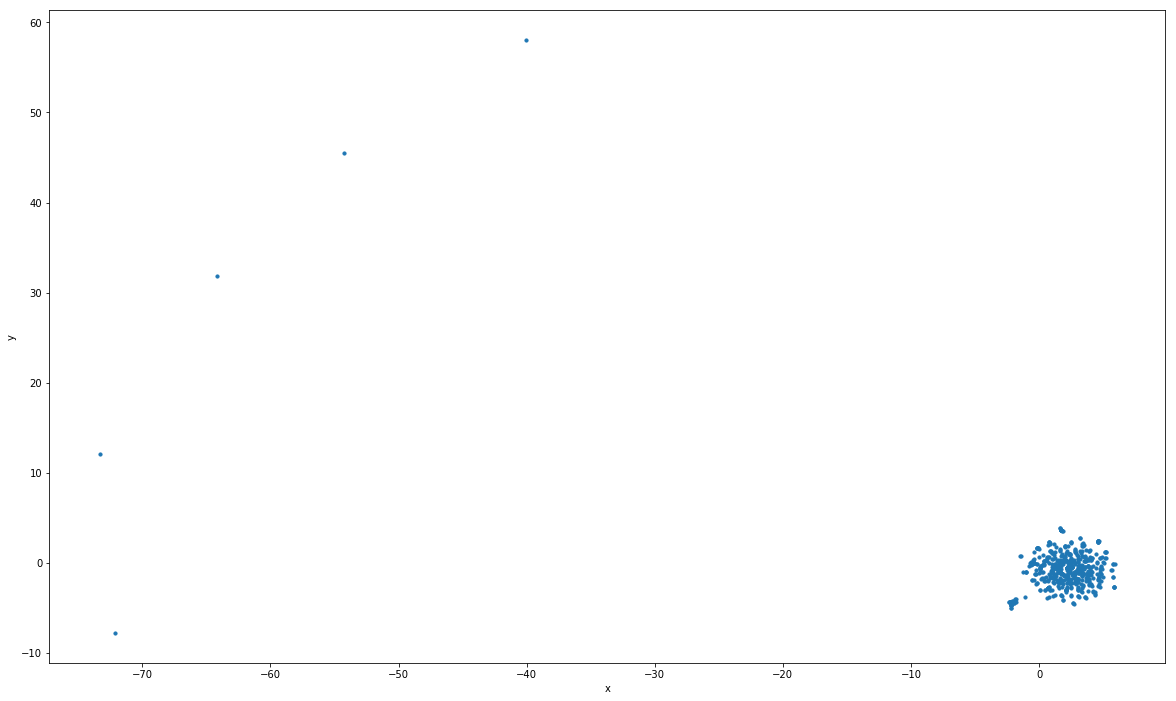

In [164]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [135]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

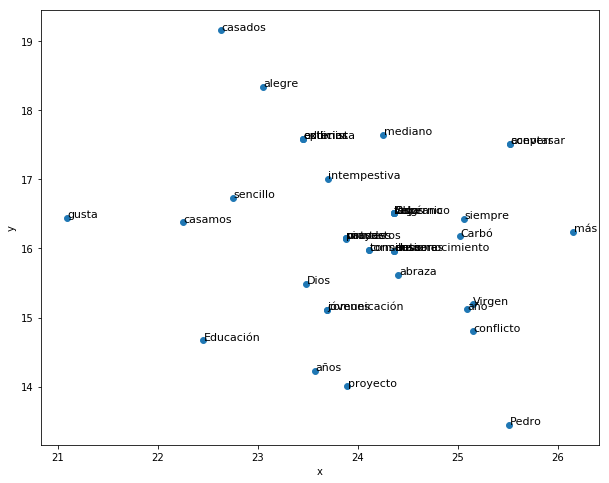

In [149]:
plot_region(x_bounds=(20, 30), y_bounds=(10, 20))

In [154]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [166]:
c50 =  clustering(50)
c100 = clustering(100)
c150 = clustering(150)

In [35]:
filename = "trained/lavoz_cluster50.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c50, fileObj)
fileObj.close()

In [38]:
filename = "trained/lavoz_cluster100.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c100, fileObj)
fileObj.close()

In [40]:
filename = "trained/lavoz_cluster150.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c150, fileObj)
fileObj.close()

In [133]:
filename = "trained/lavoz_cluster100.pickle"
with open(filename, 'rb') as f:
    clusters = pickle.load(f)

In [131]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

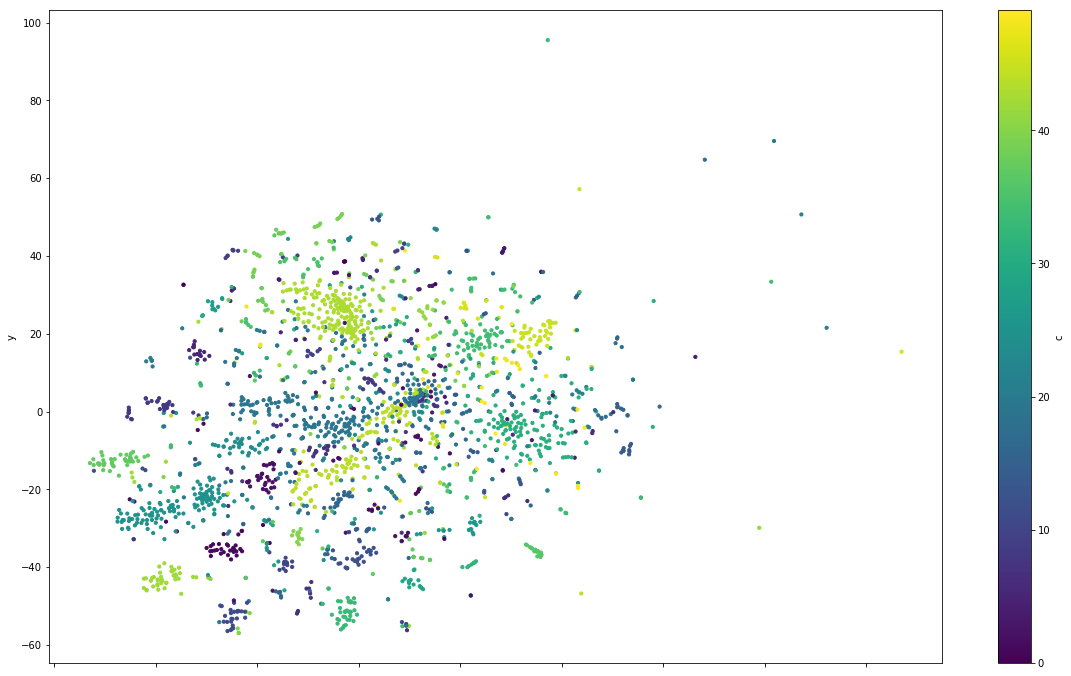

In [139]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [140]:
def plot_region_cluster(x_bounds, y_bounds):
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

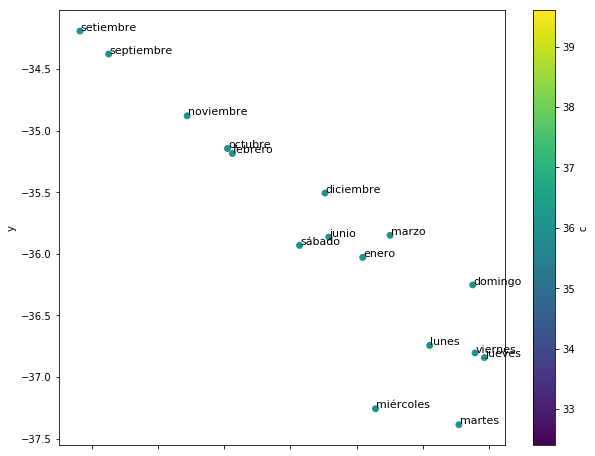

In [141]:
plot_region_cluster(x_bounds=(30, 50), y_bounds=(-45, -30))

In [134]:
# Stopwords
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["de"]]]
print(printer)

['también', 'hacia', 'estar', 'en', 'que', 'no', 'a', 'porque', 'por', 'aun', 'quien', 'te', 'le', 'durante', 'sin', 'de', 'y', 'luego', 'poder', 'según', 'finalmente', 'comer', 'con', 'ya', 'se', 'ser', 'muy', 'o']


In [135]:
# Días de la semana y meses
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["jueves"]]]
print(printer)

['septiembre', 'diciembre', 'julio', 'jueves', 'domingo', 'junio', 'octubre', 'lunes', 'enero', 'martes', 'noviembre', 'viernes', 'sábado', 'miércoles', 'setiembre', 'febrero', 'donde', 'marzo']


In [136]:
# Nombres propios
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["pedro"]]]
print(printer)

['blanco', 'vicente', 'eduardo', 'guerra', 'abril', 'ferreyra', 'horacio', 'alberto', 'silvia', 'pedro', 'omar', 'elettore', 'antonio']


In [138]:
# Funcionarios públicos
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["presidente"]]]
print(printer)

['embajador', 'decano', 'intendente', 'jefe', 'anuncio', 'viceintendente', 'senador', 'presidente', 'ministro', 'gobernador', 'vice', 'secretario', 'coordinador', 'subsecretario', 'director', 'dictador']
